In [1]:
# etl
import numpy as np 
import pandas as pd

# visuals
import matplotlib.pyplot as plt
import seaborn as sns 

# preprocessing & modelling 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# model algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor, LinearRegression
from xgboost import XGBRegressor

# model validation
from sklearn import metrics

import os

In [2]:
# from script folder to data folder
path_to_script = os.getcwd()
parent_dir = os.path.dirname(path_to_script)

In [3]:
df = pd.read_csv(parent_dir + "/data/main_df_main_pre_estim.csv")
df_h3y = pd.read_csv(parent_dir + "/data/main_df_h3y_pre_estim.csv")


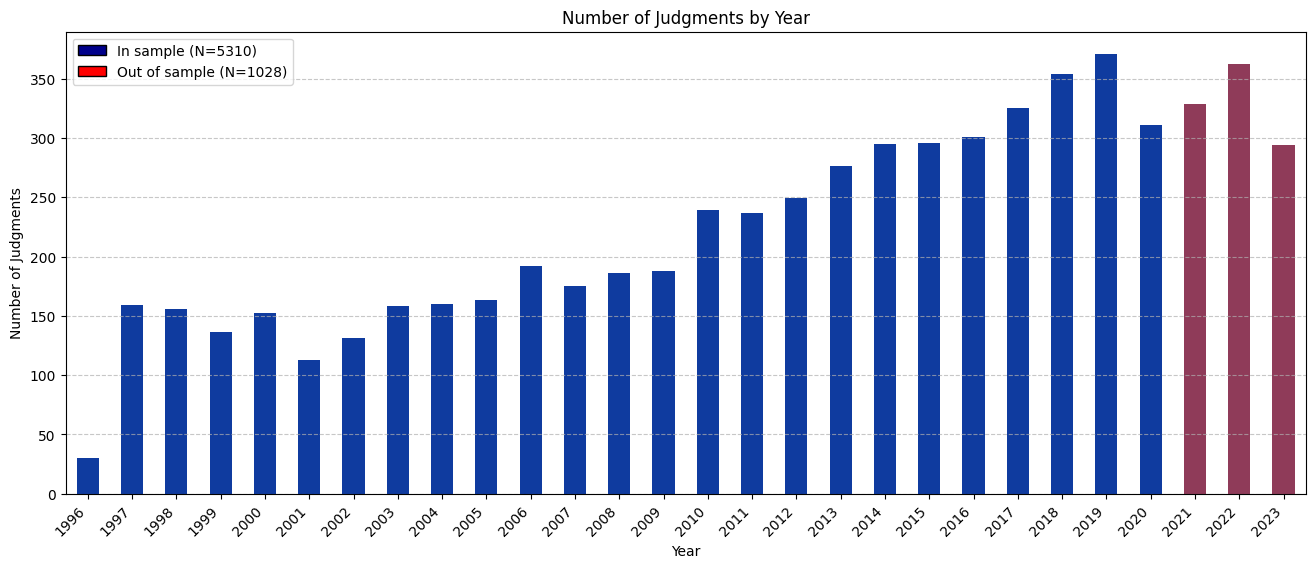

In [4]:
tmp = df.year_judgment.value_counts().sort_index()
tmp.index = tmp.index.astype(int)

fig, ax = plt.subplots(figsize=(16, 6))

ax = tmp.plot(kind='bar')

legend_labels = {
    'Dark Blue': {'label': f'In sample (N=5310)', 'color': 'darkblue'},
    'Light Blue': {'label': f'Out of sample (N=1028)', 'color': 'red'}
}

ax = tmp.plot(kind='bar', y='count', color=[legend_labels['Dark Blue']['color'] if year <= 2020 else legend_labels['Light Blue']['color'] for year in tmp.index], legend=False, alpha = .5)
ax.legend(handles=[plt.Rectangle((0,0),1,1, color=legend_labels[key]['color'], ec="k") for key in legend_labels.keys()],
          labels=[legend_labels[key]['label'] for key in legend_labels.keys()], loc='best')

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')


plt.xlabel('Year')
plt.ylabel('Number of Judgments')
plt.title('Number of Judgments by Year')
plt.savefig(parent_dir + "/github/precedential-value-ML/figures/judgments_by_year.jpg", format='jpeg', dpi=300, bbox_inches='tight')
plt.show()




In [5]:
y = df_h3y["hit_count"] 

filtered_columns = [col for col in df_h3y.columns if "country_oo_mat_" in col]
country_oo_mat = df_h3y.loc[:, filtered_columns]
filtered_columns = [col for col in df_h3y.columns if "jrs_mat_" in col]
jrs_mat = df_h3y.loc[:, filtered_columns]
filtered_columns = [col for col in df_h3y.columns if "judges_mat_" in col]
judges_mat = df_h3y.loc[:, filtered_columns]
filtered_columns = [col for col in df_h3y.columns if "amicus_mat_" in col]
amicus_mat = df_h3y.loc[:, filtered_columns]
filtered_columns = [col for col in df_h3y.columns if "operative_part_mat_" in col]
operative_pt_mat = df_h3y.loc[:, filtered_columns]

X = pd.concat([                
                 df_h3y["affectsR"]
                ,df_h3y["affectsL"]
                ,df_h3y["affectsD"]
                ,df_h3y["affectsCJ"]
                ,df_h3y["affectsT"]
                ,df_h3y["prior_touches_min_vec"] # TODO: why minvec
                ,df_h3y["act_scores"] # legal acts affected
                ,df_h3y["year_lodgment"]
                ,jrs_mat # rows depend on df
                ,df_h3y["textlength"]
                ,df_h3y["days_it_took"]
                ,df_h3y["num_citations_vec"]
                ,df_h3y["cosine_sims_vec"]
                ,df_h3y["subj_cosine_sims_vec"]
                ,operative_pt_mat # rows depend on df
                ,df_h3y["grand_chamber"]
                ,judges_mat # rows depend on df
                ,df_h3y["chamber_size"]
                ,country_oo_mat  # rows depend on df
                ,df_h3y["country_of_origin_weights"]
                ,df_h3y["num_obs_vec"] # num_obs_vec # rows depends on df
                #,amicus_mat # rows depends on df
                ,df_h3y["amicus_curiae_weights"]
                
                ,df_h3y["lagged_hit_ratio"] 
                #,df_h3y["lagged_hit_count"] 
                 ]
                 ,axis=1)

# for descriptive statistics:
X_plot = pd.concat([                
                 df_h3y["affectsR"]
                ,df_h3y["affectsL"]
                ,df_h3y["affectsD"]
                ,df_h3y["affectsCJ"]
                ,df_h3y["affectsT"]
                ,df_h3y["prior_touches_min_vec"] # TODO: why minvec
                ,df_h3y["act_scores"] # legal acts affected
                ,df_h3y["year_lodgment"]
                ,df_h3y["textlength"]
                ,df_h3y["days_it_took"]
                ,df_h3y["num_citations_vec"]
                ,df_h3y["cosine_sims_vec"]
                ,df_h3y["subj_cosine_sims_vec"]
                ,df_h3y["grand_chamber"]
                ,df_h3y["chamber_size"]
                ,df_h3y["country_of_origin_weights"]
                ,df_h3y["num_obs_vec"] # num_obs_vec # rows depends on df
                #,amicus_mat # rows depends on df
                ,df_h3y["amicus_curiae_weights"]
                
                ,df_h3y["lagged_hit_ratio"] 
                #,df_h3y["lagged_hit_count"] 
                 ]
                 ,axis=1)


X.columns = X.columns.astype(str)
X["textlength"].fillna(int(np.mean(X["textlength"])), inplace = True)


/var/folders/3p/ynx9h1ws7mqfb01ljsgzgs600000gn/T/ipykernel_5078/3371179815.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["textlength"].fillna(int(np.mean(X["textlength"])), inplace = True)


In [6]:
tab_desc = X_plot.describe().T
tab_desc = tab_desc.loc[:,tab_desc.columns.isin(['count', 'mean', 'std', 'min', 'max'])]
tab_desc["count"] = tab_desc["count"].astype(int)
tab_desc["mean"] = np.round(tab_desc["mean"],2)
tab_desc["std"] = np.round(tab_desc["std"],2)
tab_desc["min"] = np.round(tab_desc["min"],2)
tab_desc["max"] = np.round(tab_desc["max"],2)
tab_desc

,count,mean,std,min,max
affectsR,5310,0.29,0.46,0.00,1.00
affectsL,5310,0.51,0.50,0.00,1.00
affectsD,5310,0.02,0.14,0.00,1.00
affectsCJ,5310,0.01,0.10,0.00,1.00
affectsT,5310,0.20,0.40,0.00,1.00
prior_touches_min_vec,5310,33.81,71.43,0.00,408.00
act_scores,5310,-0.06,0.71,-1.00,1.59
year_lodgment,5310,2009.01,7.05,1995.00,2019.00
textlength,5286,6888.59,3545.02,1.00,53818.00
days_it_took,5310,581.72,184.14,40.00,2056.00


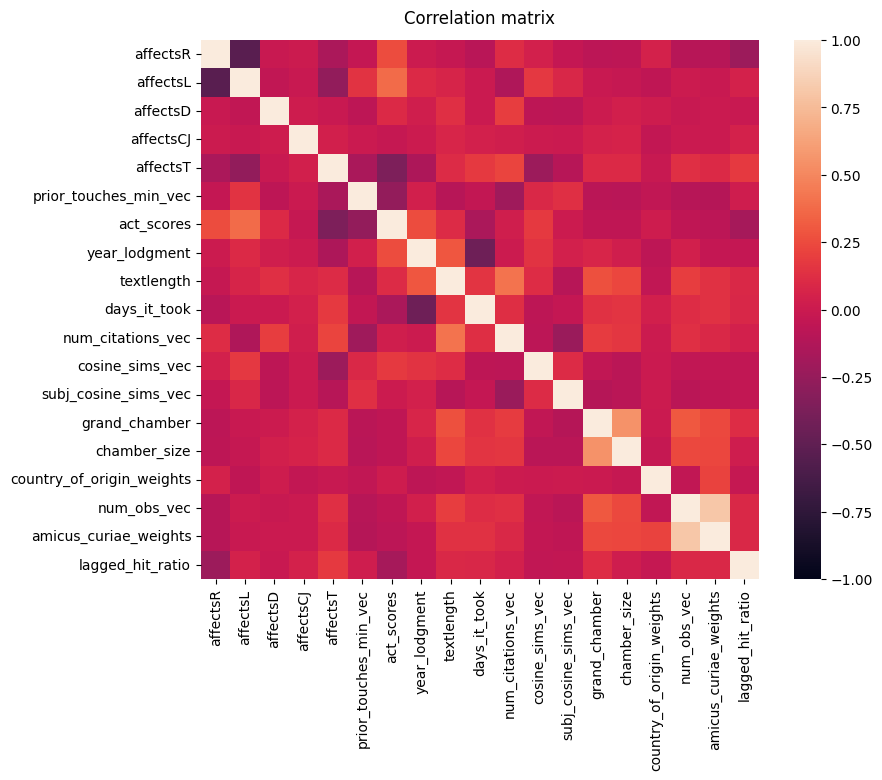

In [7]:
plt.figure(figsize=(9, 7))
heatmap = sns.heatmap(X_plot.corr(), vmin=-1, vmax=1, annot=False)
heatmap.set_title('Correlation matrix', fontdict={'fontsize':12}, pad=12);
plt.savefig(parent_dir + "/github/precedential-value-ML/figures/corrplot.jpg", format='jpeg', dpi=300, bbox_inches='tight')
plt.show()
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.heatmap = sns.heatmap(dataframe.corr(), vmin=-1, vmax=1, annot=True)# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
algorithm_candidates = [
    ('Random Forest',
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(random_state=42, n_jobs=3))
        ]),
        {
            'model__n_estimators': [1000],
            'model__max_depth': [3, 10, 11, 12, 13],
            'model__min_samples_split': [2, 3],
            'model__min_samples_leaf': [10, 11, 12]
        }
    ),
    ('XGBoost',
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', XGBRegressor(random_state=42, n_jobs=3))
        ]),
        {
            'model__n_estimators': [1000],
            'model__max_depth': [3, 4, 5],
            'model__learning_rate': [0.01],
            'model__min_child_weight': [2, 3,4]
        }
    ),
    ('Linear Regression',
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', LinearRegression())
        ]),
        {
            # Linear Regression has no hyperparameters to tune
        }
    ),
    ('SVM', Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR())
    ]), {
        'model__C': [0.0005,0.001,0.002], # , 1, 10 margin of misclassification
        'model__kernel': ['linear', 'rbf','poly'],
        'model__epsilon': [0.5,1,1.5]
    }),
    ('SGD', Pipeline([
        ('scaler', StandardScaler()),
        ('model', SGDRegressor(random_state = 42))
    ]), {
        'model__alpha': [0.008, 0.01, 0.012], # 0.0001, 0.001,
        'model__max_iter': [1000], # 2000
        'model__tol': [1e-2/2,1e-2, 1e-2*2], 
        'model__eta0': [0.04,0.05,0.06],
    })

]
best_algorithm = None
best_hyperparameters = None
best_score = float('inf') # init to infinity
full_results = []
for algo_name, model, param_grid in algorithm_candidates:
    # inner loop: Hyperparameter optimization (within each model !?)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error',n_jobs=3) # ,n_jobs=-1 # (cores)
    grid_search.fit(X_train, y_train)
    # get the best hyperparameters from grid search (takes place within each model !?)
    best_params = grid_search.best_params_
    # evaluate the model with the best hyperparameters on the test set
    model = model.set_params(**best_params)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, preds_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, preds_test))
    mae_train = np.sqrt(metrics.mean_absolute_error(y_train, preds_train))
    mae_test = np.sqrt(metrics.mean_absolute_error(y_test, preds_test))
    # update the best algorithm if needed
    if rmse_test < best_score:
        best_score = rmse_test
        best_algorithm = algo_name
        best_hyperparameters = best_params
        best_predictions = preds_test
    # show full results
    full_results.append([algo_name
                         ,best_params
                         ,np.round(rmse_train,4)
                         , np.round(rmse_test,4)
                         ,np.round(mae_train,4)
                         , np.round(mae_test,4)])
print(f"Best Algorithm: {best_algorithm}")
print(f"Best Hyperparameters: {best_hyperparameters}")
print(f"Best RMSE: {np.round(best_score,4)}")
print(f"RMSE of mean test: {np.round(np.sqrt(np.mean(y_test**2)),4)}")
print(f"RMSE im Verhältnis zu simple mean: {np.round(best_score / np.sqrt(np.mean(y_test**2)) * 100,4)}%")
# RMSE im Verhältnis zu simple mean: 79.51% (Best: 75.65%)    

full_results
# runtime: 16min30 

Best Algorithm: XGBoost
Best Hyperparameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_child_weight': 4, 'model__n_estimators': 1000}
Best RMSE: 2.0939
RMSE of mean test: 3.122
RMSE im Verhältnis zu simple mean: 67.0707%


[['Random Forest',
  {'model__max_depth': 13,
   'model__min_samples_leaf': 12,
   'model__min_samples_split': 2,
   'model__n_estimators': 1000},
  1.8661,
  2.1296,
  1.1345,
  1.2241],
 ['XGBoost',
  {'model__learning_rate': 0.01,
   'model__max_depth': 3,
   'model__min_child_weight': 4,
   'model__n_estimators': 1000},
  1.9412,
  2.0939,
  1.1825,
  1.2145],
 ['Linear Regression', {}, 2.129, 2.1615, 1.2272, 1.2309],
 ['SVM',
  {'model__C': 0.002, 'model__epsilon': 1.5, 'model__kernel': 'linear'},
  2.23,
  2.2212,
  1.2393,
  1.236],
 ['SGD',
  {'model__alpha': 0.012,
   'model__eta0': 0.04,
   'model__max_iter': 1000,
   'model__tol': 0.005},
  158407369844.4252,
  141552643834.5884,
  203222.0203,
  204914.1781]]

In [9]:
# model performances

print(f"RMSE of mean test: {np.round(np.sqrt(np.mean(y_test**2)),4)}")
print(f"MAE of mean test: {np.round(np.mean(np.abs(y_test)),4)}")

out = []
for i in range(len(full_results)):
    out.append([full_results[i][0], # Algorithm 
                full_results[i][3], # test RMSE
                np.round(1-full_results[i][3]/np.sqrt(np.mean(y_test**2)), 4), 
                full_results[i][5], # test MAE
                np.round(1-full_results[i][5]/np.mean(np.abs(y_test)), 4)
                ]
                )

out = pd.DataFrame(out, columns=["algorithm","rmse","reduction in rmse","mae","reduction in mae"])
out = out[out["algorithm"] != "SGD"]
out.sort_values("rmse", ascending=False)


RMSE of mean test: 3.122
MAE of mean test: 1.9557


,algorithm,rmse,reduction in rmse,mae,reduction in mae
3,SVM,2.2212,0.2885,1.2360,0.3680
2,Linear Regression,2.1615,0.3076,1.2309,0.3706
0,Random Forest,2.1296,0.3179,1.2241,0.3741
1,XGBoost,2.0939,0.3293,1.2145,0.3790


In [12]:
# look into the best model 

bestmod = XGBRegressor(learning_rate=best_hyperparameters["model__learning_rate"]
                            , max_depth=best_hyperparameters["model__max_depth"]
                            , min_child_weight=best_hyperparameters["model__min_child_weight"]
                            , n_estimators=best_hyperparameters["model__n_estimators"]
                            , random_state = 42)
bestmod.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

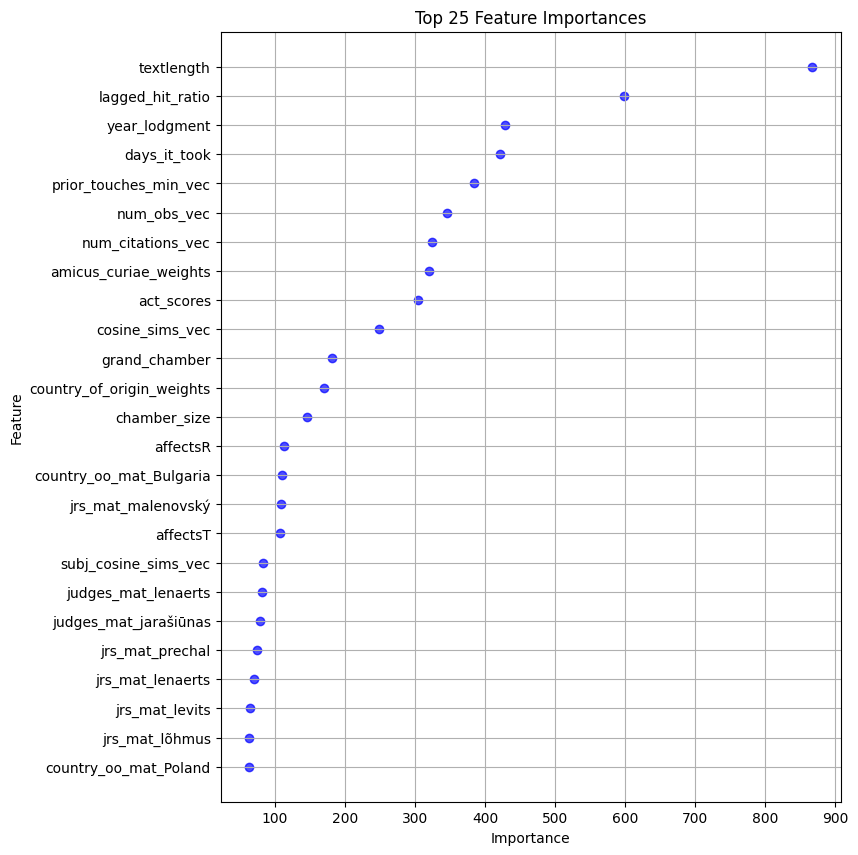

In [13]:
# best model: feature importances
import xgboost as xgb

booster = bestmod.get_booster()
importance_dict = booster.get_score(importance_type="weight")
feature_names = np.array(list(importance_dict.keys()))
feature_importances = np.array(list(importance_dict.values()))


# Sort indices based on importance in descending order
sorted_idx = feature_importances.argsort()[::-1][:25]
sorted_features_df = pd.DataFrame({'Feature': feature_names[sorted_idx], 'Importance': feature_importances[sorted_idx]})
sorted_features_df.sort_values("Importance", inplace = True)

plt.figure(figsize=(8, 10))
plt.scatter(sorted_features_df['Importance'], sorted_features_df['Feature'], color='blue', alpha=0.7)

plt.title('Top 25 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.savefig(parent_dir + "/github/precedential-value-ML/figures/feature_importance.jpg", format='jpeg', dpi=300, bbox_inches='tight')
plt.show()